In [1]:
## Updated 1-7-25

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random
import helper_scripts
import unsupervised_scripts
from tqdm import tqdm
from tkinter import filedialog, Tk


## Sample Directory (different for everyone)
data_dir = (input('Enter the path to your .tif hyperstacks: ').strip() or os.getcwd())


## Load Image

root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

directory = filedialog.askdirectory()

indeces = [index for index, char in enumerate(directory) if char=='/']
sample_name = directory[indeces[-1]+1:]


save_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/output/kmeans-'+sample_name+'/'
if os.path.exists(save_dir) is False:
  os.mkdir(save_dir)

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)):').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100):').strip() or '3100')

background_df = pd.read_csv('no_background_HSI_76.csv')

sample_list = os.listdir(directory)
max_img_list = []
for idx, image_name in tqdm(enumerate(sample_list)):
    image = io.imread(directory+'/'+image_name)
    max_img = np.max(image,axis=0)
    max_img_list.append(max_img)
    temp_vec = image.reshape((image.shape[0], image.shape[1]*image.shape[2]))
    temp_vec[np.isinf(temp_vec)] = 0
    temp_vec[np.isnan(temp_vec)] = 0
    if idx == 0:
        num_samp = int(np.shape(temp_vec)[0])
        ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
        preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)

    temp_vec = temp_vec.T
    temp_vec = preprocessing.spectral_standardization(np.flip(temp_vec,axis=1), br_shift=15)

    if idx == 0:
        image_vec = temp_vec
    else:
        image_vec = np.concatenate((image_vec, temp_vec), axis=0)


save_input = helper_scripts.save_input()

4it [00:03,  1.08it/s]


Text(0, 0.5, 'Normalized Intensity (A.U.)')

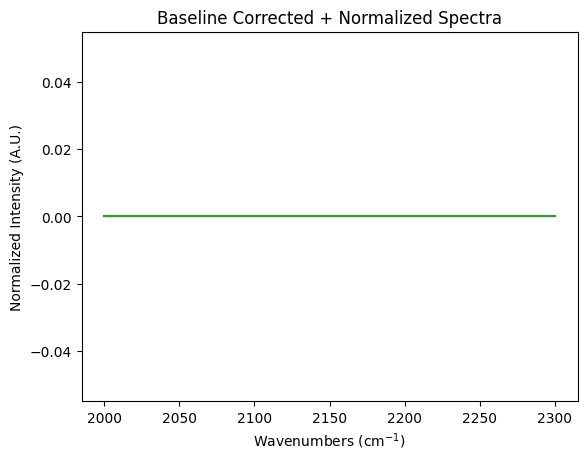

In [2]:
## Visualize random spectra for validation of preprocessing
wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_vec.shape[0]-1), random.randint(0,image_vec.shape[0]-1), random.randint(0,image_vec.shape[0]-1)]
plt.plot(wavenumbers, image_vec[indeces].T)
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [3]:
## Optimizing Silhouette Score (OPTIONAL)
kmeans_vec = unsupervised_scripts.K_means_cluster(image_vec)
cluster_range = int(input('Enter range of clusters to optimize: '))

kmeans_vec.kmeans_silhoutette_score(cluster_range+1)

ValueError: invalid literal for int() with base 10: ''

In [2]:
## Selection of k-means number (default=7)
kmeans_vec = unsupervised_scripts.K_means_cluster(image_vec)
k=int(input('Enter number of k-means centers (Default=7):').strip() or '7')
kmeans_1 = kmeans_vec.kmeans(k)

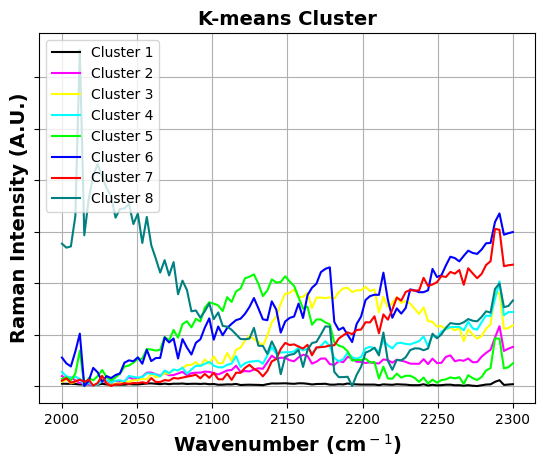

In [3]:
## Visualize Graph of Cluster Centers
graph_list = ['#000000', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k, dtype='object')
color_list[0] = '#000000'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or graph_list[i])

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
kmeans_vec.kmeans_graph(kmeans_1, wavenumbers, save_input, color_list, save_dir=save_dir+str(k)+'_Clusters-')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


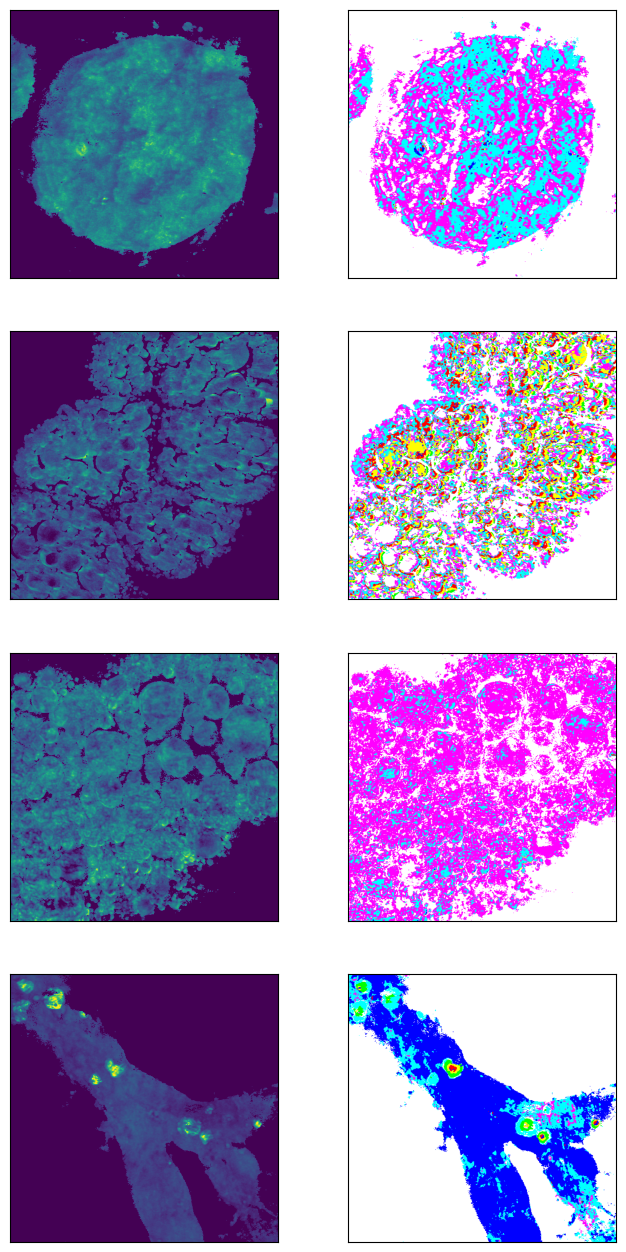

In [4]:
## Visualize Clustered Image
fig_list = ['#FFFFFF', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k, dtype='object')
color_list[0] = '#FFFFFF'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or fig_list[i])
label_idx = kmeans_vec.kmeans_image(kmeans_1, max_img_list, save_input, color_list, save_dir=save_dir+str(k)+'_Clusters-')


In [6]:
## Normalize data (ignoring background, Cluster 0)
temp_norm = image_vec[np.where(label_idx!=0)[0],:]
spectra_norm = np.empty(temp_norm.shape,dtype='float32')
for idx, spectra in enumerate(temp_norm):
    spectra_norm[idx,:] = helper_scripts.normalize(spectra)
image_norm = np.zeros(image_vec.shape, dtype='float32')
image_norm[np.where(label_idx!=0),:] = spectra_norm

In [ ]:
## Optimizing Silhouette Score (OPTIONAL)
kmeans_norm = unsupervised_scripts.K_means_cluster(image_norm)
cluster_range = int(input('Enter range of clusters to optimize: '))

kmeans_norm.kmeans_silhoutette_score(cluster_range+1)

In [8]:
## Selection of k-means number (default=7)
kmeans_norm = unsupervised_scripts.K_means_cluster(image_norm)
k_norm=int(input('Enter number of k-means centers (Default=7):').strip() or '7')
kmeans_2 = kmeans_norm.kmeans(k_norm)

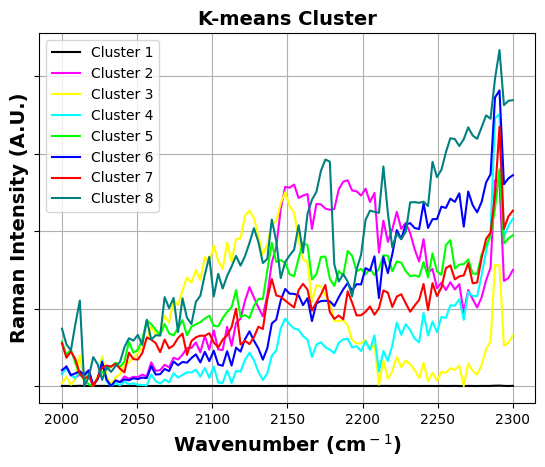

In [9]:
## Visualize Graph of Cluster Centers
graph_list = ['#000000', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k_norm, dtype='object')
color_list[0] = '#000000'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or graph_list[i])

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
kmeans_norm.kmeans_graph(kmeans_2, wavenumbers, save_input, color_list, save_dir=save_dir+'normalized-'+str(k_norm)+'_Clusters-')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


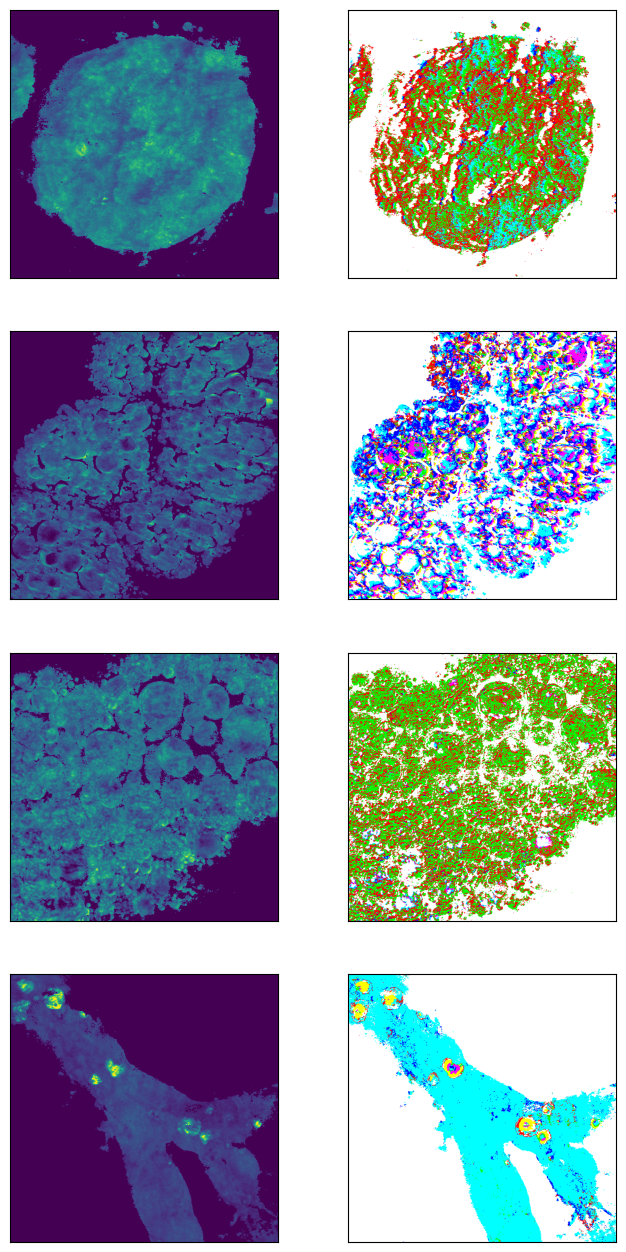

array([0., 0., 0., ..., 5., 7., 7.])

In [10]:
## Visualize Clustered Normalized Spectra
fig_list = ['#FFFFFF', '#FF00FF', '#FFFF00', '#00FFFF', '#00FF00','#0000FF','#FF0000', '#008080','#FFA500', '#800080']
color_list = np.empty(k_norm, dtype='object')
color_list[0] = '#FFFFFF'
for i in range(1,len(color_list)):
    color_list[i] = (input('Enter hexcode for cluster '+str(i+1)+": ").strip() or fig_list[i])
kmeans_norm.kmeans_image(kmeans_2, max_img_list, save_input, color_list, save_dir=save_dir+'normalized-'+str(k_norm)+'_Clusters-')